# Applied Time Series

## Exercise 2: Fama-MacBeth Regressions

We run Fama-Macbeth regressions on a dataset of five US investment banks (yes, not so original) considering the 5 traditional Fama-French factors (...). 

The work is structured as follows:
1. Import data
2. Fama-Macbeth #1
3. Fama-Macbeth #2
4. Data visualisation

## 1. Import data

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
import urllib.request
import zipfile
import statsmodels.api as sm
import warnings

In [2]:
start_date = '1980-03-18'
end_date = '2021-12-29'
ret = yf.download(['JPM','GS','C','BAC','MS'],start_date,end_date)
ret=ret.iloc[:,0:5] # the fifth column returns the adjusted close
ret=ret.pct_change() 
ret=ret.dropna()
ret.columns = ret.columns.droplevel()
ret

[*********************100%***********************]  5 of 5 completed


,BAC,C,GS,JPM,MS
Date,,,,,
1999-05-05,0.007099,0.006920,-0.017761,-0.025076,0.011473
1999-05-06,-0.020265,-0.040378,-0.017179,-0.032735,-0.043479
1999-05-07,0.011691,0.004476,0.091077,0.010476,0.061265
1999-05-10,-0.016889,0.016934,-0.046375,0.007974,-0.027933
1999-05-11,-0.001809,0.016653,-0.000884,0.012659,0.030013
...,...,...,...,...,...
2021-12-21,0.023865,0.018874,0.023439,0.013966,0.025165
2021-12-22,0.002037,0.003705,0.005285,0.003908,0.005421
2021-12-23,0.003162,0.010235,0.007088,0.003574,0.010580


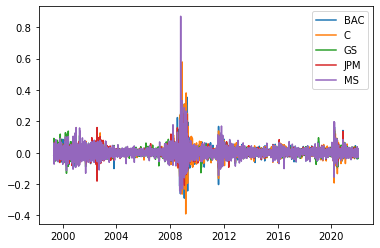

In [3]:
plt.plot(ret)
plt.legend(ret.columns)

We download the Fama-French five factors from the authors' website. Those are:
- Mkt-RF (market factor)
- SMB (small minus big)
- HML (high minus low B/M)
- RMW (robust minus weak OP)
- CMA (conservative minus aggressive Inv)

In [4]:
ff_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip'
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
zip_file.extractall()
zip_file.close()
factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv', skiprows = 3, index_col = 0)
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
19630701,-0.67,0.01,-0.35,0.03,0.11,0.012
19630702,0.79,-0.31,0.24,-0.08,-0.25,0.012
19630703,0.63,-0.16,-0.09,0.13,-0.24,0.012
19630705,0.40,0.09,-0.26,0.07,-0.28,0.012
19630708,-0.63,0.07,-0.19,-0.27,0.06,0.012
...,...,...,...,...,...,...
20220325,0.27,-0.29,2.17,0.19,1.33,0.000
20220328,0.73,-0.88,-1.69,0.49,-1.19,0.000
20220329,1.45,1.18,-1.92,-0.30,-0.97,0.000
20220330,-0.83,-1.12,0.39,0.39,0.94,0.000


We match the two dataframes to make the observation dates uniform

In [5]:
factors.index = pd.to_datetime(factors.index, format= '%Y%m%d')
factors=factors.join(ret)
factors=factors.dropna(axis=0)
factors.index.name='Date'
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF,BAC,C,GS,JPM,MS
Date,,,,,,,,,,,
1999-05-05,1.03,-0.96,-0.03,-0.61,-0.49,0.017,0.007099,0.006920,-0.017761,-0.025076,0.011473
1999-05-06,-1.15,1.06,1.05,0.54,1.07,0.017,-0.020265,-0.040378,-0.017179,-0.032735,-0.043479
1999-05-07,0.89,-0.44,-0.24,-0.23,-0.49,0.017,0.011691,0.004476,0.091077,0.010476,0.061265
1999-05-10,-0.03,1.12,0.15,-0.83,-0.26,0.017,-0.016889,0.016934,-0.046375,0.007974,-0.027933
1999-05-11,1.19,-0.23,-0.83,-0.48,-0.29,0.017,-0.001809,0.016653,-0.000884,0.012659,0.030013
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-21,2.06,0.66,0.18,-1.08,-0.20,0.000,0.023865,0.018874,0.023439,0.013966,0.025165
2021-12-22,0.97,0.18,-0.36,0.31,0.07,0.000,0.002037,0.003705,0.005285,0.003908,0.005421
2021-12-23,0.71,0.28,-0.48,-0.37,-0.36,0.000,0.003162,0.010235,0.007088,0.003574,0.010580


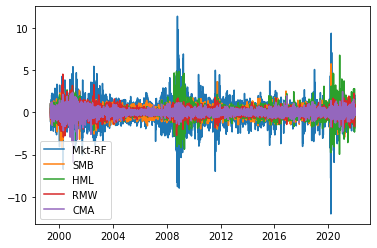

In [6]:
plt.plot(factors.iloc[:,0:5])
plt.legend(factors.iloc[:,0:5])

We can now separate back the returns dataframe

In [7]:
returns=factors.iloc[:,6:11]
returns

,BAC,C,GS,JPM,MS
Date,,,,,
1999-05-05,0.007099,0.006920,-0.017761,-0.025076,0.011473
1999-05-06,-0.020265,-0.040378,-0.017179,-0.032735,-0.043479
1999-05-07,0.011691,0.004476,0.091077,0.010476,0.061265
1999-05-10,-0.016889,0.016934,-0.046375,0.007974,-0.027933
1999-05-11,-0.001809,0.016653,-0.000884,0.012659,0.030013
...,...,...,...,...,...
2021-12-21,0.023865,0.018874,0.023439,0.013966,0.025165
2021-12-22,0.002037,0.003705,0.005285,0.003908,0.005421
2021-12-23,0.003162,0.010235,0.007088,0.003574,0.010580


**To sum up**: at the end of the first part we have two datasets:
 - returns of five US banks
 - five factors 
that are observed over daily and over the same timeframe. We are now ready to implement the econometric analysis.x

## 2. Fama-Macbeth: part 1

Fama-Macbeth regressions are a two-step process that allow us to estimate risk premia in a consistent way. In particular, this methodology aims at estimating standard errors that are corrected for the cross-sectional correlation that is inevitably present in the panel dataset. 

The **first regression** aims at estimating factor exposures: we estimate five linear regression models for each of the factors, to obtain a beta matrix

In [14]:
betas = []
X = factors[['BAC','C','GS','JPM','GS']]
Y = factors[['Mkt-RF','SMB','HML','RMW','CMA']]
step1 = sm.OLS(endog=X,exog=sm.add_constant(Y))
warnings.filterwarnings("ignore")
results = step1.fit()
betas.append(results.params.drop('const'))
betas=pd.DataFrame(betas[0])
betas

,0,1,2,3,4
Mkt-RF,0.012591,0.013763,0.012042,0.012577,0.012042
SMB,-0.004837,-0.004750,-0.002347,-0.003926,-0.002347
HML,0.021046,0.019441,0.009215,0.014371,0.009215
RMW,-0.005372,-0.006514,-0.004612,-0.005273,-0.004612
CMA,-0.011347,-0.011137,-0.007714,-0.006660,-0.007714


In [15]:
betas.columns=['BAC','C','GS','JPM','GS']
betas=betas.T
betas

,Mkt-RF,SMB,HML,RMW,CMA
BAC,0.012591,-0.004837,0.021046,-0.005372,-0.011347
C,0.013763,-0.004750,0.019441,-0.006514,-0.011137
GS,0.012042,-0.002347,0.009215,-0.004612,-0.007714
JPM,0.012577,-0.003926,0.014371,-0.005273,-0.006660
GS,0.012042,-0.002347,0.009215,-0.004612,-0.007714


We have now obtained a 5x5 beta matrix where we have estimated the factor exposures for each stock return of our dataset

## 3. Fama-Macbeth: part 2

We can now estimate a linear regression at each observation time versus the betas that we previously estimated. This will result in a lambda matrix that contains Tx5 estimations. We then consider the average of those risk premia.

In [16]:
lambdas = []
for period in returns.index:
    step2 = sm.OLS(endog=returns.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)
lambdas=pd.DataFrame(lambdas, index=returns.index)
lambdas

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1999-05-05,-10.004868,-0.685766,-0.494863,-10.808847,-7.235392
1999-05-06,5.263073,4.434155,1.045412,21.434144,-2.473263
1999-05-07,20.299120,10.662329,-7.193708,35.654013,-13.274669
1999-05-10,-19.629365,-11.476203,0.717492,-49.908459,9.559457
1999-05-11,-6.237158,-4.237200,-1.210138,-20.716328,2.608370
...,...,...,...,...,...
2021-12-21,3.614501,1.959599,-0.054872,7.807527,-2.726074
2021-12-22,0.454988,-0.013715,-0.362214,-0.504168,-0.101926
2021-12-23,-2.167221,-0.827541,-1.298654,-6.926752,-1.459960


In [17]:
lambda_est=lambdas.mean()
lambda_est

Mkt-RF    0.250317
SMB       0.075176
HML       0.044872
RMW       0.487730
CMA       0.049431
dtype: float64

## 4. Data visualization

We propose some graph that will help us grasp the practical meaning of the previous work. 
- First, we can visualize the relative importance of each of the five factor loadings
- Then, we can consider their historical evolution (both jointly and separately)


This helps us to understand how each factor's importance varies over time.

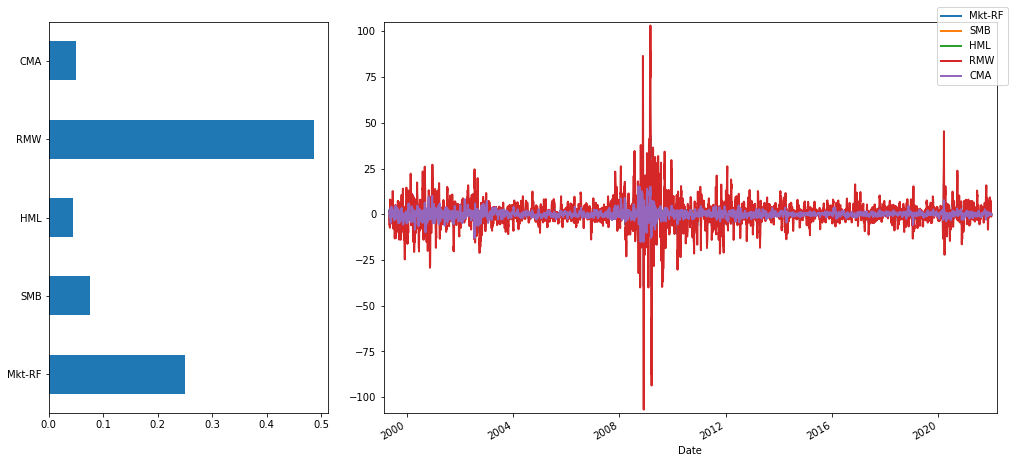

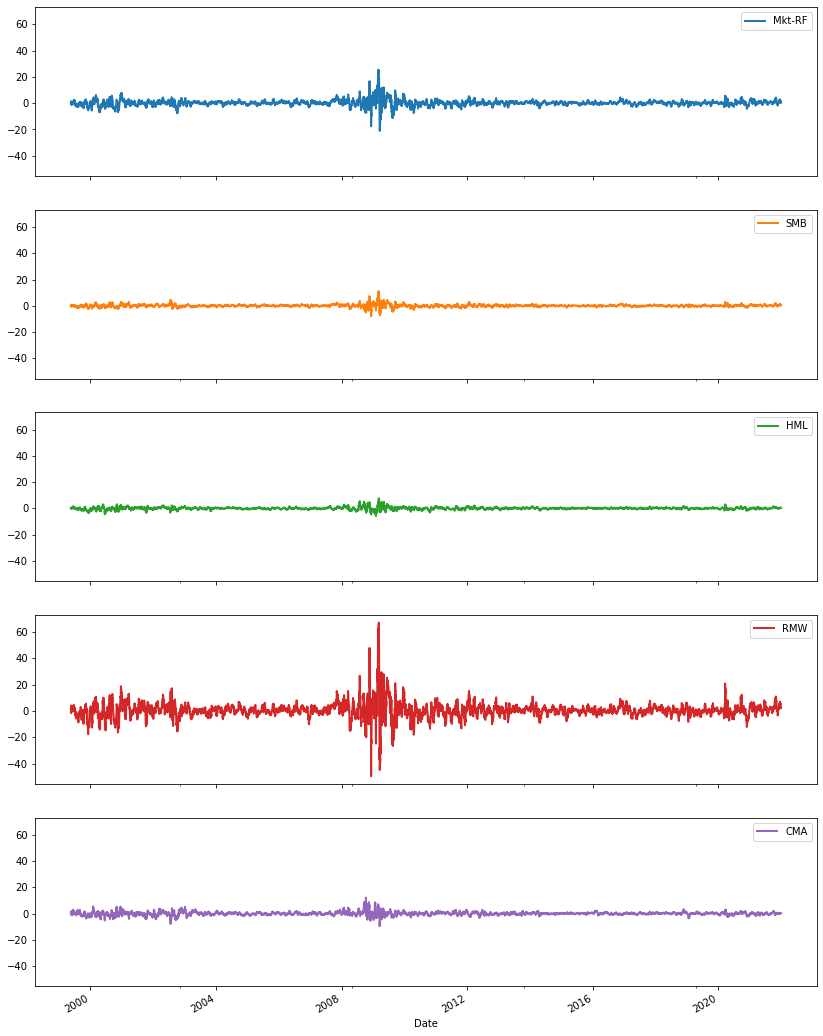

In [18]:
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
ax2.margins(0.01)
lambdas.mean().plot.barh(ax=ax1)
lambdas0 = lambdas.rolling(6).mean().dropna()
lambdas0.plot(lw=2, figsize=(17,8), ax=ax2)
ax2.legend(bbox_to_anchor=(1.025, 1.05))
plt.show()

lambdas.rolling(12).mean().dropna().plot(lw=2, figsize=(14,20), subplots=True, sharey=True, sharex=True)
plt.show()

## 5. Interpretation

We see that the most influent factor is the RMW, which is interpretable as the **profitability factor**. This means that banks that were most "profitable" (in a broader sense) were also the one that exhibited greater returns over the examined sample. 

We see that this finding is coherent with the economic theory: as interest rates dropped after the GFC, banks had to search for new ways to boost their revenues. So the market gave a larger premium to the banks that managed to do so. 

The analysis can be refined by considering more homogeneous subsamples (ie, after 2007).

By contrast, the lower risk premium is given to the HML factor, which is the **growth factor**. This may be due to the fact that we examined companies of the same sector, which tend to behave similarly when it comes to dividend distribution.